# Summary
* Purpose: Compute resolution functions for PbTe CNCS dataset on a grid
* Procedure:
  - Simulate beam
  - Prepare sample
  - Simulate resolution
  - Fit each resolution function and save fitting parameters
  - Try interpolation of the fitting parameters
* Ei=12meV
* T=150K? Tyson's slice says it is 300K?

* sample cylinder radius=.5cm height=3.5cm at psi=0, the orientation of the axis is [-1,0,1] (x is beam, z is vertical up). u=002, v=220

# Tools

In [1]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2'

** Modify the workdir !!! **

In [2]:
workdir = "/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1/"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1


In [3]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, os, glob
import histogram.hdf as hh, histogram as H

In [4]:
!which mcvine

/home/lj7/dv/mcvine/export/bin/mcvine


In [5]:
import mcvine.cli

In [6]:
from dgsres.singlextal import use_res_comps
reload( use_res_comps )

<module 'dgsres.singlextal.use_res_comps' from '/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/singlextal/use_res_comps.pyc'>

# Beam

was already simulated in PbTe-explore-one-point.ipynb

# Sample

was already created in PbTe-explore-one-point.ipynb

In [8]:
cat {workdir}/sample.yaml

name: PbTe
chemical_formula: PbTe
lattice: 
 constants: 6.461, 6.461, 6.461, 90, 90, 90
 basis_vectors:
  - 6.461, 0, 0
  - 0, 6.461, 0
  - 0, 0, 6.461
excitations:
 - type: DGSresolution
orientation:
 u: 0, 0, 2
 v: 2, 2, 0
shape: |
       <rotation angles="-45.*deg, 0.*deg, 0.*deg">
         <cylinder radius=".5*cm" height="3.5*cm"/>
       </rotation>
temperature: 100*K

In [17]:
sampleyml = os.path.join(workdir, 'sample.yaml')

# CNCS Instrument

In [9]:
beam = "/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1/beam/"
instrument = use_res_comps.instrument(
    name = 'CNCS',
    detsys_radius = "3.5*meter",
    L_m2s = "36.264*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_res_comps.pixel(
    radius = "0.5*inch",
    height = "2.*meter/128",
    pressure = "6*atm",
    )

# psi scan

In [10]:
class psi_scan:
    min = -74.
    max = 50.
    step = 1.

# mcvine simulation

In [11]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/PbTe-try1


** Define projection direction and starting point **

In [12]:
hkl_projection = np.array([1,1,0])

In [13]:
hkl0 = np.array([0,0,4])
hkl0

array([0, 0, 4])

** Define points of interest **

In [14]:
E_arr = np.arange(-6, 6, 2.)
q_arr = np.arange(-2, 2, 0.5)

In [20]:
valid_pairs = []
for E in E_arr:
    for q in q_arr:
        hkl = hkl0 + hkl_projection*q
        dir1 = 'sim-q%s-E%s' % (q,E)
        try:
            use_res_comps.setup(
                dir1,
                sampleyml, beam, E, hkl, hkl_projection,
                psi_scan, instrument, pixel)
        except:
            continue
        valid_pairs.append((q,E))
        continue
    continue

Ei=12.1196524, t0=136.433557094
Computed:
* psi=4.50285915816 degree
* Q=[  4.09385379e+00  -2.43670268e+00   4.10686751e-16]
* hkl2Qmat=[[ -5.39863181e-02   6.85523853e-01  -6.87646330e-01]
 [ -5.39863181e-02   6.85523853e-01   6.87646330e-01]
 [  9.69477130e-01   7.63481833e-02  -8.35061464e-18]]
* ki=2.41845180576
* vectors ki=[ 2.41845181  0.          0.        ], kf=[ -1.67540199e+00   2.43670268e+00  -4.10686751e-16]
These two numbers should be very close:
  -6.0
  -6.0
  Ei=12.1196524, Ef=18.1196524
* Ef=18.1196524
* pixel positon=[ -1.98298662e+00   2.88405341e+00  -4.86084140e-16]
* pixel_position=[ -1.98298662e+00   2.88405341e+00  -4.86084140e-16]
t_m2s=0.0239518666718, t_s2p=0.00187984037657, t_m2p=0.0258317070484
Ei=12.1196524, t0=136.433557094
Computed:
* psi=-11.3154586494 degree
* Q=[  3.40953122e+00  -2.78608208e+00  -3.10183332e-16]
* hkl2Qmat=[[  1.34923575e-01   6.74279693e-01  -6.87646330e-01]
 [  1.34923575e-01   6.74279693e-01   6.87646330e-01]
 [  9.53575486e-01

In [22]:
len(valid_pairs)

44

** add MC parameter file **

In [26]:
cat test/mc_params.yml

Nbuffer: 100000
Nrounds_beam: 10

In [23]:
import shutil

In [25]:
for q,E in valid_pairs:
    dir1 = 'sim-q%s-E%s' % (q,E)
    shutil.copyfile('./test/mc_params.yml', os.path.join(dir1, 'mc_params.yml'))
    continue

** Create script to run all sims **

using 20 cores

In [35]:
cores = 20
path = 'run-sims.sh'
with open(path, 'wt') as ostream:
    ostream.write('parallel --max-procs %s << EOF\n' % cores)
    for q,E in valid_pairs:
        dir1 = 'sim-q%s-E%s' % (q,E)
        ostream.write('cd %s && python run.py &>log.run\n' % os.path.abspath(dir1))
        continue
    ostream.write('EOF\n')

In [40]:
!chmod +x run-sims.sh

In [38]:
#cat run-sims.sh

** Run simulation. This will take 30~60minutes **

In [42]:
%%bash
./run-sims.sh

In [45]:
ls sim*/res.h5 |wc -l

44


# Fit resolution functions

In [174]:
from dgsres.singlextal import fit2ee
reload(fit2ee)

<module 'dgsres.singlextal.fit2ee' from '/home/lj7/dv/mcvine/export/lib/python2.7/site-packages/dgsres/singlextal/fit2ee.pyc'>

In [175]:
Ei = 12

In [176]:
q_arr

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [177]:
E_arr

array([-6., -4., -2.,  0.,  2.,  4.])

** Load data **

In [178]:
%%time
Nq = len(q_arr)
NE = len(E_arr)
fitters = dict()
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        print (q,E)
        dir1 = 'sim-q%s-E%s' % (q,E)
        fitter = fit2ee.Fit2EE(dir1, qaxis=(-0.3, 0.3, 0.002), Eaxis=(-3, 2, 0.02), Ei=Ei, E=E)
        fitters[(q,E)] = fitter
        fitter.load_mcvine_psf_qE()
        continue
    continue

(-2.0, 0.0)
(-2.0, -2.0)
(-2.0, -4.0)
(-2.0, -6.0)
(-1.5, 2.0)
(-1.5, 0.0)
(-1.5, -2.0)
(-1.5, -4.0)
(-1.5, -6.0)
(-1.0, 4.0)
(-1.0, 2.0)
(-1.0, 0.0)
(-1.0, -2.0)
(-1.0, -4.0)
(-1.0, -6.0)
(-0.5, 4.0)
(-0.5, 2.0)
(-0.5, 0.0)
(-0.5, -2.0)
(-0.5, -4.0)
(-0.5, -6.0)
(0.0, 4.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, -2.0)
(0.0, -4.0)
(0.0, -6.0)
(0.5, 4.0)
(0.5, 2.0)
(0.5, 0.0)
(0.5, -2.0)
(0.5, -4.0)
(0.5, -6.0)
(1.0, 4.0)
(1.0, 2.0)
(1.0, 0.0)
(1.0, -2.0)
(1.0, -4.0)
(1.0, -6.0)
(1.5, 2.0)
(1.5, 0.0)
(1.5, -2.0)
(1.5, -4.0)
(1.5, -6.0)
CPU times: user 18.7 s, sys: 6.94 s, total: 25.7 s
Wall time: 27.4 s


** Plot **

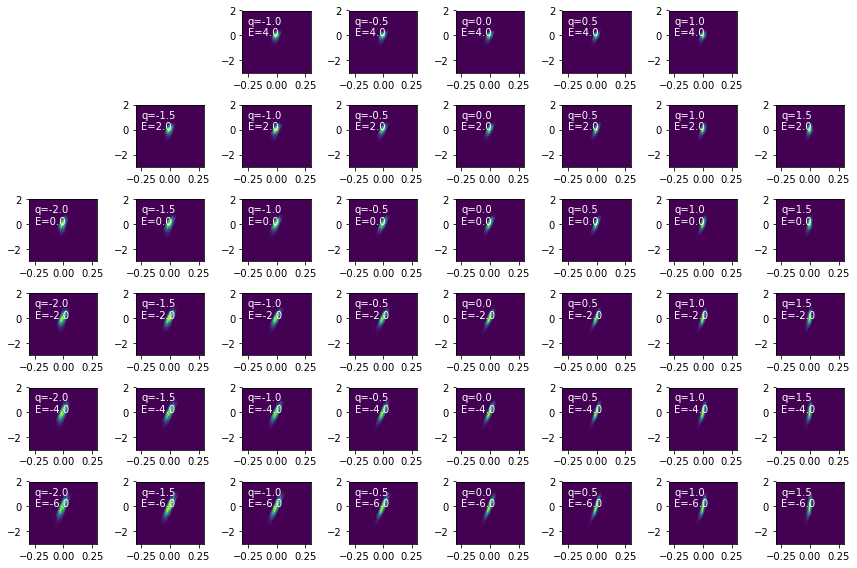

In [217]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        fitter = fitters[(q,E)]
        hist = fitter.mcvine_psf_qE
        qgrid, Egrid = fitter.qEgrids
        plt.pcolormesh(qgrid, Egrid, hist.I.T, cmap='viridis')
        ax.text(-0.25,0.,  "q=%s\nE=%s" % (q,E), color='white')
        continue
    continue
plt.tight_layout()

## Fitting one case

[ 0.18463256  0.27651328  0.6947826   0.59748301]


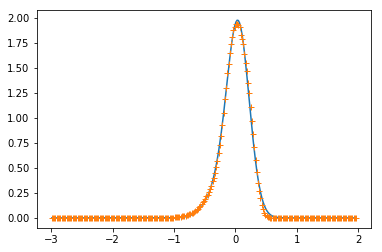

In [187]:
fitter = fitters[(0., 4.)]
fitted_params, res_x, res_y, yfit, E_profile = \
    fitter.fit_E_profile(sigma_left=0.3, sigma_right=0.2, ef_width=.1, weight_left=.5)
print fitted_params
plt.figure()
plt.plot(res_x, yfit)
# plt.plot(res_x, E_profile(res_x))
plt.plot(res_x, res_y, '+')

25000.0
25000.0


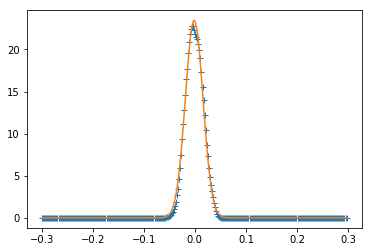

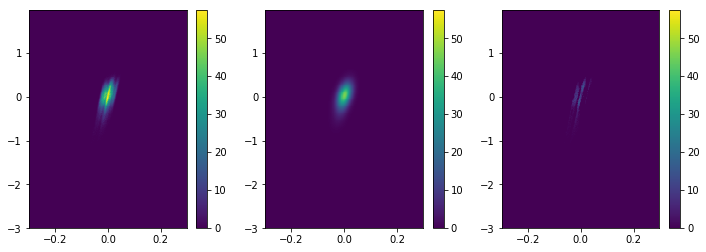

In [186]:
popt, res_x, res_y, yfit, q_profile = fitter.fit_q_profile(sigma=0.1)
plt.figure()
plt.plot(res_x, res_y, '+')
plt.plot(res_x, yfit)

fitted_parameters, qgrid, Egrid, res_z, zfit, qE_profile = fitter.fit_qE_profile(dq_over_dE=0.02)
print np.sum(res_z)
print np.sum(zfit)
diff = res_z - zfit

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.pcolormesh(qgrid, Egrid, res_z, cmap='viridis')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(qgrid, Egrid, zfit, cmap='viridis')
plt.clim(0, np.max(res_z))
plt.colorbar()
plt.subplot(1,3,3)
plt.pcolormesh(qgrid, Egrid, diff, cmap='viridis')
plt.clim(0, np.max(res_z))
plt.colorbar()

## Fit all points

In [252]:
%%time
model_params = dict()
for q,E in valid_pairs:
    print q,E
    fitter = fitters[(q, E)]
    E_fitted_params, res_x, res_y, yfit, E_profile = fitter.fit_E_profile(
        sigma_left=(0.1,0.5), sigma_right=(0.1, 0.5), ef_width=(0.49, 0.51), weight_left=(0.4,.8))
    popt, res_x, res_y, yfit, q_profile = fitter.fit_q_profile(sigma=0.1)
    q_sigma = popt[-1]
    qE_fitted_params, qgrid, Egrid, res_z, zfit, qE_profile = fitter.fit_qE_profile(dq_over_dE=0.02)
    dq_over_dE = qE_fitted_params[0]
    sigma_left, sigma_right, weight_left, ef_width = E_fitted_params
    model_params[(float(q),float(E))] = dict(
        sigma_left=float(np.abs(sigma_left)), 
        sigma_right=float(np.abs(sigma_right)),
        weight_left=float(weight_left),
        ef_width=float(ef_width),
        q_sigma = float(np.abs(q_sigma)),
        dq_over_dE = float(dq_over_dE),
    )
    continue

-2.0 -6.0
-1.5 -6.0
-1.0 -6.0
-0.5 -6.0
0.0 -6.0
0.5 -6.0
1.0 -6.0
1.5 -6.0
-2.0 -4.0
-1.5 -4.0
-1.0 -4.0
-0.5 -4.0
0.0 -4.0
0.5 -4.0
1.0 -4.0
1.5 -4.0
-2.0 -2.0
-1.5 -2.0
-1.0 -2.0
-0.5 -2.0
0.0 -2.0
0.5 -2.0
1.0 -2.0
1.5 -2.0
-2.0 0.0
-1.5 0.0
-1.0 0.0
-0.5 0.0
0.0 0.0
0.5 0.0
1.0 0.0
1.5 0.0
-1.5 2.0
-1.0 2.0
-0.5 2.0
0.0 2.0
0.5 2.0
1.0 2.0
1.5 2.0
-1.0 4.0
-0.5 4.0
0.0 4.0
0.5 4.0
1.0 4.0
CPU times: user 5.82 s, sys: 28 ms, total: 5.85 s
Wall time: 5.79 s


** Plot fitted PSFs **

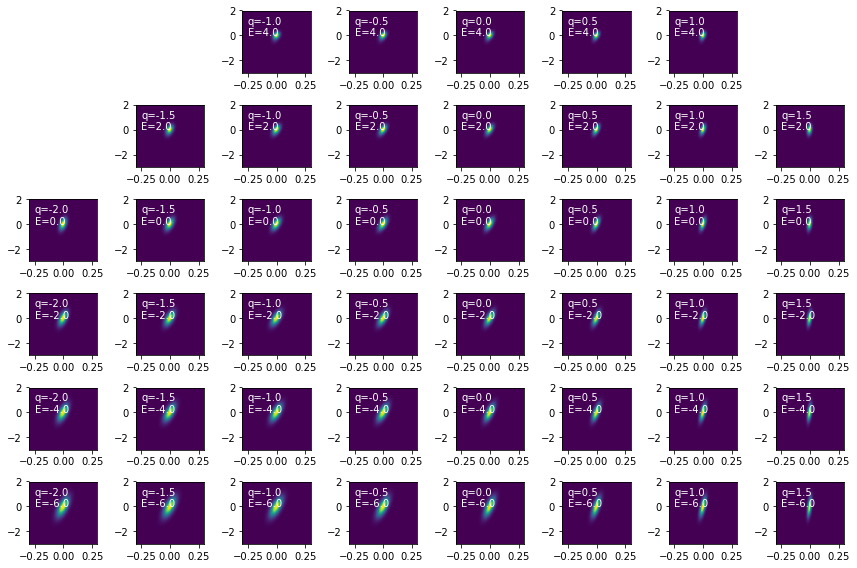

In [216]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr):
    for iE, E in enumerate(E_arr[::-1]):
        if (q,E) not in valid_pairs:
            continue
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        fitter = fitters[(q,E)]
        qgrid, Egrid = fitter.qEgrids
        I = fitter.model.qE_profile(qgrid, Egrid)
        # print np.min(I), np.max(I), np.isnan(I).sum()
        plt.pcolormesh(qgrid, Egrid, I, cmap='viridis')
        ax.text(-0.25,0., "q=%s\nE=%s" % (q,E), color='white')
        continue
    continue
plt.tight_layout()

# Interpolation

In [253]:
model_params

{(-2.0, -6.0): {'dq_over_dE': 0.041900057195662116,
  'ef_width': 0.51,
  'q_sigma': 0.02710202680967795,
  'sigma_left': 0.5,
  'sigma_right': 0.5,
  'weight_left': 0.5126183814771348},
 (-2.0, -4.0): {'dq_over_dE': 0.04015104481112893,
  'ef_width': 0.51,
  'q_sigma': 0.024419241674164927,
  'sigma_left': 0.4401822341847352,
  'sigma_right': 0.43521362732815744,
  'weight_left': 0.5192163167164061},
 (-2.0, -2.0): {'dq_over_dE': 0.036130507222013455,
  'ef_width': 0.51,
  'q_sigma': 0.021646790689277263,
  'sigma_left': 0.3692470552549802,
  'sigma_right': 0.3726409509338861,
  'weight_left': 0.5309616826755749},
 (-2.0, 0.0): {'dq_over_dE': 0.02648626400286048,
  'ef_width': 0.5088658322449973,
  'q_sigma': 0.018615754774885626,
  'sigma_left': 0.3037882180720846,
  'sigma_right': 0.3192085451487598,
  'weight_left': 0.5579996088488839},
 (-1.5, -6.0): {'dq_over_dE': 0.045122610882096695,
  'ef_width': 0.51,
  'q_sigma': 0.027868259099382245,
  'sigma_left': 0.5,
  'sigma_right': 0.

In [255]:
import yaml
with open('eeafine-params.yaml', 'wt') as of:
    yaml.dump(model_params, of, default_flow_style=False)

In [256]:
cat eeafine-params.yaml

? !!python/tuple
- -2.0
- -6.0
: dq_over_dE: 0.041900057195662116
  ef_width: 0.51
  q_sigma: 0.02710202680967795
  sigma_left: 0.5
  sigma_right: 0.5
  weight_left: 0.5126183814771348
? !!python/tuple
- -2.0
- -4.0
: dq_over_dE: 0.04015104481112893
  ef_width: 0.51
  q_sigma: 0.024419241674164927
  sigma_left: 0.4401822341847352
  sigma_right: 0.43521362732815744
  weight_left: 0.5192163167164061
? !!python/tuple
- -2.0
- -2.0
: dq_over_dE: 0.036130507222013455
  ef_width: 0.51
  q_sigma: 0.021646790689277263
  sigma_left: 0.3692470552549802
  sigma_right: 0.3726409509338861
  weight_left: 0.5309616826755749
? !!python/tuple
- -2.0
- 0.0
: dq_over_dE: 0.02648626400286048
  ef_width: 0.5088658322449973
  q_sigma: 0.018615754774885626
  sigma_left: 0.3037882180720846
  sigma_right: 0.3192085451487598
  weight_left: 0.5579996088488839
? !!python/tuple
- -1.5
- -6.0
: dq_over_dE: 0.045122610882096695
  ef_width: 0.51
  q_sigma: 0.027868259099382245
  sigma_left: 0.5
  sigma_right: 0.5
  w

In [257]:
model_params2 = yaml.load(open('eeafine-params.yaml'))

In [258]:
from dgsres import interp; reload(interp)
ip = interp.InterpedParameters(model_params2)

In [259]:
ip.at(0., 0.)

{'dq_over_dE': array([ 0.04426038]),
 'ef_width': array([ 0.51]),
 'q_sigma': array([ 0.01902752]),
 'sigma_left': array([ 0.30598965]),
 'sigma_right': array([ 0.31376652]),
 'weight_left': array([ 0.54577765])}

In [260]:
model = fit2ee.EEAffineModel(Ei=12, E=None)
qgrid, Egrid = fitter.qEgrids

** slightlly shift the q and E points, and see if interpolation works **

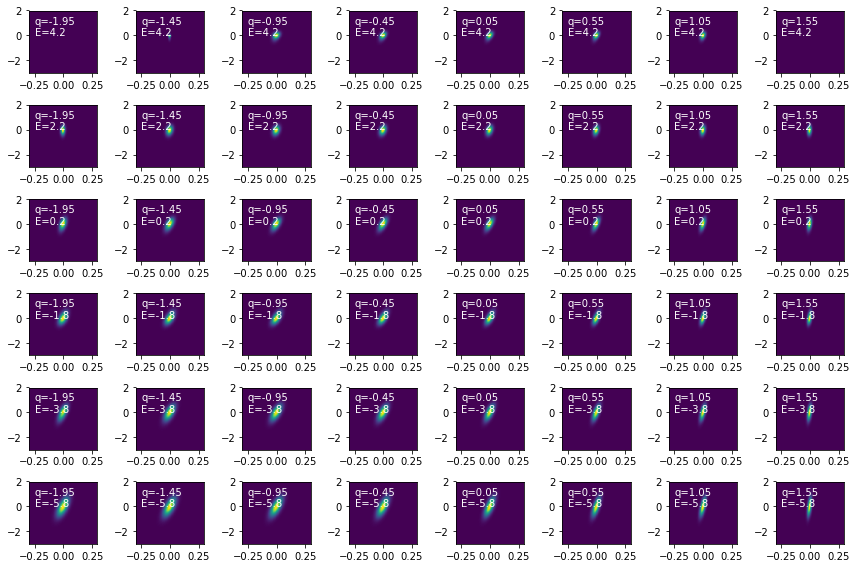

In [261]:
plt.figure(figsize=(12, 8))
for iq, q in enumerate(q_arr+.05):
    for iE, E in enumerate(E_arr[::-1]+.2):
        # print (q,E)
        ax=plt.subplot(NE, Nq, iE*Nq+iq+1)
        model.E = E
        model.update_parameters(**ip.at(q, E))
        I = model.qE_profile(qgrid, Egrid)
        # print np.min(I), np.max(I), np.isnan(I).sum()
        plt.pcolormesh(qgrid, Egrid, I, cmap='viridis')
        ax.text(-0.25,0., "q=%s\nE=%s" % (q,E), color='white')
        continue
    continue
plt.tight_layout()